<a href="https://colab.research.google.com/github/Raiden900/kepfeldolgozas-beadando-2025/blob/main/Kepfeldolgozas_beadando.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q opencv-python-headless easyocr pytesseract matplotlib numpy
# Ha kell a Tesseract bináris:
# !apt-get update && apt-get install -y tesseract-ocr tesseract-ocr-eng

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 17.2 MB/s eta 0:00:00


In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pytesseract, easyocr
from google.colab import files

def show(img, title=None, size=(6,6)):
    plt.figure(figsize=size)
    if img.ndim==2: plt.imshow(img, cmap='gray')
    else: plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    if title: plt.title(title)
    plt.axis('off'); plt.show()

Saving IMG_1107.jpeg to IMG_1107.jpeg


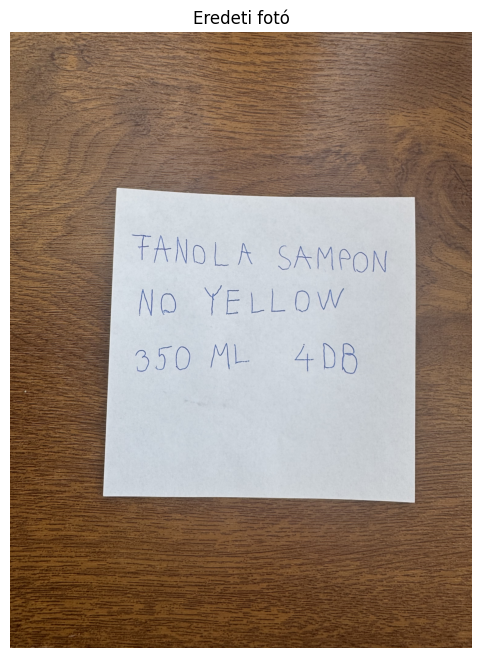

In [3]:
uploaded = files.upload()   # válaszd ki a fotót (pl. fanola.jpg)
fname = list(uploaded.keys())[0]
img = cv.imdecode(np.frombuffer(uploaded[fname], np.uint8), cv.IMREAD_COLOR)
show(img, "Eredeti fotó", (8,8))

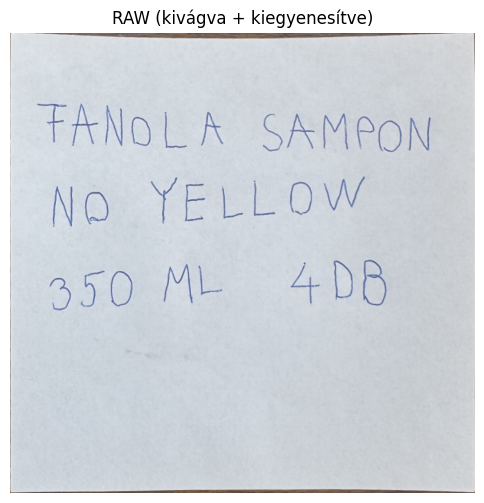

In [4]:
def largest_quad_contour(binary):
    cnts,_ = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    best=None; area=0
    for c in cnts:
        peri=cv.arcLength(c,True)
        approx=cv.approxPolyDP(c,0.02*peri,True)
        if len(approx)==4:
            a=cv.contourArea(approx)
            if a>area: best=approx; area=a
    return best

def order_pts(pts):
    pts=pts.reshape(4,2).astype(np.float32)
    s=pts.sum(1); d=np.diff(pts, axis=1).ravel()
    tl=pts[np.argmin(s)]; br=pts[np.argmax(s)]
    tr=pts[np.argmin(d)]; bl=pts[np.argmax(d)]
    return np.array([tl,tr,br,bl], np.float32)

def warp_document(image_bgr, target_width=1200):
    ratio = target_width / image_bgr.shape[1]
    img = cv.resize(image_bgr, (target_width, int(image_bgr.shape[0]*ratio)))
    gray=cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    gray=cv.GaussianBlur(gray,(5,5),0)
    edges=cv.Canny(gray,60,180)
    edges=cv.dilate(edges,np.ones((3,3),np.uint8),1)
    quad=largest_quad_contour(edges)
    if quad is None: return img, False
    pts=order_pts(quad)
    w=int(max(np.linalg.norm(pts[1]-pts[0]), np.linalg.norm(pts[2]-pts[3])))
    h=int(max(np.linalg.norm(pts[3]-pts[0]), np.linalg.norm(pts[2]-pts[1])))
    M=cv.getPerspectiveTransform(pts, np.array([[0,0],[w-1,0],[w-1,h-1],[0,h-1]], np.float32))
    warped=cv.warpPerspective(img, M, (w,h))
    return warped, True

raw, ok = warp_document(img)
show(raw, "RAW (kivágva + kiegyenesítve)")

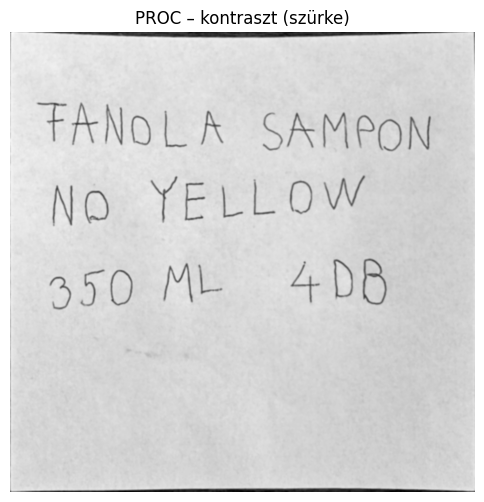

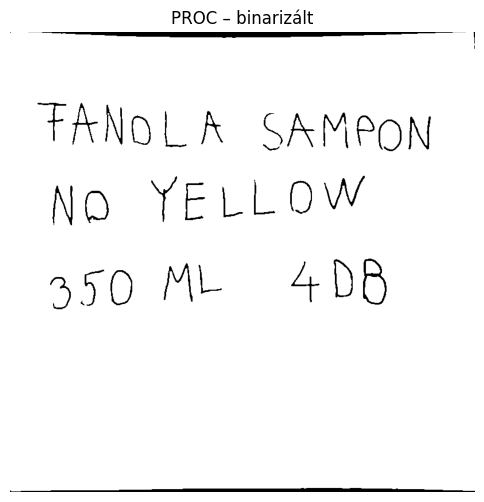

In [5]:
def enhance_for_ocr(bgr):
    gray = cv.cvtColor(bgr, cv.COLOR_BGR2GRAY)
    # finom denoise – kevesebb szemcse
    gray = cv.GaussianBlur(gray, (5,5), 0)
    # globális Otsu a mostani textúrára jobb, mint az adaptív
    _, binimg = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    # apró pöttyök eltávolítása
    binimg = cv.morphologyEx(binimg, cv.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=1)
    return gray, binimg

gray, binimg = enhance_for_ocr(raw)
show(gray, "PROC – kontraszt (szürke)")
show(binimg, "PROC – binarizált")

In [8]:
reader = easyocr.Reader(['en'], gpu=False)

def ocr_easy(img_gray):
    res = reader.readtext(
        img_gray,
        detail=0,
        paragraph=True,
        decoder='beamsearch',     # 🔹 pontosabb, de kicsit lassabb
        text_threshold=0.4,       # 🔹 jobban felismeri a halvány betűket
        low_text=0.3
    )
    return "\n".join(res)

def ocr_tess(img_gray):
    cfg = "--oem 1 --psm 4 -l eng"
    return pytesseract.image_to_string(img_gray, config=cfg)

txt_raw_ez  = ocr_easy(cv.cvtColor(raw, cv.COLOR_BGR2GRAY))
txt_proc_ez = ocr_easy(binimg)
txt_raw_te  = ocr_tess(cv.cvtColor(raw, cv.COLOR_BGR2GRAY))
txt_proc_te = ocr_tess(binimg)

print("=== EasyOCR RAW ===\n", txt_raw_ez)
print("\n=== EasyOCR PROC ===\n", txt_proc_ez)
print("\n=== Tesseract RAW ===\n", txt_raw_te)
print("\n=== Tesseract PROC ===\n", txt_proc_te)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== EasyOCR RAW ===
 FANoL# SAMPON No YELLOW 350 ML 4D8

=== EasyOCR PROC ===
 FANoLt SAMPON No YELLOW 350 ML 4 DB

=== Tesseract RAW ===
 tk ae al
TANOLA SAMPON
NOR EL Om
550 ML ADB


=== Tesseract PROC ===
 FANOLA SAMPON
No YELLOW
—50 ML 4DB



In [9]:
import difflib
expected = "FANOLA SAMPON NO YELLOW 350 ML 4 DB"
def sim(a,b): return difflib.SequenceMatcher(None,a.upper().strip(),b.upper().strip()).ratio()
for name, txt in [("Easy RAW",txt_raw_ez),("Easy PROC",txt_proc_ez),
                  ("Tess RAW",txt_raw_te),("Tess PROC",txt_proc_te)]:
    print(f"{name:10s} -> match={sim(expected, txt):.2f}")

Easy RAW   -> match=0.93
Easy PROC  -> match=0.97
Tess RAW   -> match=0.67
Tess PROC  -> match=0.90


In [ ]:
import os, json
os.makedirs("/content/outputs", exist_ok=True)
cv.imwrite("/content/outputs/raw.jpg", raw)
cv.imwrite("/content/outputs/proc_bin.png", binimg)
with open("/content/outputs/ocr.json","w",encoding="utf-8") as f:
    json.dump({"easy_raw":txt_raw_ez,"easy_proc":txt_proc_ez,
               "tess_raw":txt_raw_te,"tess_proc":txt_proc_te}, f, ensure_ascii=False, indent=2)
print("Mentve: /content/outputs")

Mentve: /content/outputs
